# A data-driven early warning system for Escherichia coli in water based on microbial community analysis using flow cytometry 2D histograms.

### Load the packages and point to the files that store the raw data

In [3]:
import sys

if sys.version_info.major == 3 and sys.version_info.minor >= 10:
    import collections
    setattr(collections, "MutableMapping", collections.abc.MutableMapping)
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import FlowCytometryTools
from FlowCytometryTools import test_data_dir,test_data_file
datadir=test_data_dir
datafile=test_data_file
from FlowCytometryTools import FCMeasurement
import os
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


from sklearn.ensemble import RandomForestClassifier
ran_for=RandomForestClassifier(n_estimators=100)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
log_reg=LogisticRegression(max_iter=1000,penalty=None)
import seaborn as sns

from sklearn.decomposition import PCA
pca = PCA(n_components=2)

datafolder='data2/'
pixels=8 # pixels*pixels,  hyperparameter
reruns=500

## Data preparation 
Values of FCM FL1-A and FL3-A are log10 transformed before applying a 8x8 gate. Value counts of each pixel are extracted and stored as row majors.

In [5]:
samples=os.listdir('./data2')
Df=pd.DataFrame(np.zeros([len(samples),pixels*pixels]),index=samples)
kolumner=list(Df.columns.values)
nyakolumner=[]
for i in range(len(kolumner)):
  nyakolumner.append(''+str(i))
Df.columns=nyakolumner
Df['ECOLI']=np.nan
for i in range(len(samples)):
    datafile=datafolder+samples[i]
    sample=FCMeasurement(ID='Test Sample',datafile=datafile)    
    frame=sample.data
    frame2=frame[['FL1-A','FL3-A']]
    frame3=frame2.replace(to_replace=0,value=1)
    frame4=np.log10(frame3)
    framefiltered=frame4[(frame4['FL1-A']>=3.3) & (frame4['FL1-A']<=6) & 
                     (frame4['FL3-A']>=1) & (frame4['FL3-A']<= ( 3 + ((5-3)/(6-3.3))*(frame4['FL1-A']-3.3) ) )  ]
    for y in range(pixels):
        for x in range(pixels):
            winminx=3.3+ ((6-3.3)/pixels)*x
            winmaxx=(3.3+ ((6-3.3)/pixels) ) + ((6-3.3)/pixels)*x        
            winminy=(5-  (5-1)/pixels ) - ((5-1)/pixels)*y
            winmaxy=5 - ((5-1)/pixels)*y
            Df.iloc[i,(x+y*pixels)]= framefiltered[(framefiltered['FL1-A']>=winminx) & (framefiltered['FL1-A']<winmaxx) & 
                                (framefiltered['FL3-A']>=winminy) & (framefiltered['FL3-A']< winmaxy ) ].shape[0]
Df

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,ECOLI
A02 B1 1-20 a v28 SY.fcs,0.0,0.0,0.0,0.0,0.0,0.0,32.0,17.0,0.0,0.0,...,0.0,34.0,12.0,7.0,3.0,0.0,0.0,0.0,0.0,NaN
A02 B1 1-20 a v29 SY.fcs,0.0,0.0,0.0,0.0,0.0,0.0,7.0,2.0,0.0,0.0,...,0.0,13.0,4.0,7.0,1.0,0.0,0.0,0.0,0.0,NaN
A02 B1 1-20 a v30 SY.fcs,0.0,0.0,0.0,0.0,0.0,0.0,8.0,18.0,0.0,0.0,...,0.0,15.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,NaN
A02 B1 1-20 a v31 SY.fcs,0.0,0.0,0.0,0.0,0.0,0.0,12.0,10.0,0.0,0.0,...,0.0,15.0,2.0,6.0,1.0,0.0,0.0,0.0,0.0,NaN
A02 B1 1-20 a v32 SY.fcs,0.0,0.0,0.0,0.0,0.0,0.0,14.0,12.0,0.0,0.0,...,0.0,9.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B06 B6 1-20 c v31 SY.fcs,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,...,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
B06 B6 1-20 c v32 SY.fcs,0.0,0.0,0.0,0.0,0.0,0.0,8.0,5.0,0.0,0.0,...,0.0,6.0,4.0,3.0,1.0,0.0,0.0,0.0,0.0,NaN
B06 B6 1-20 c v33 SY.fcs,0.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,0.0,0.0,...,0.0,12.0,12.0,7.0,1.0,0.0,0.0,0.0,0.0,NaN
B06 B6 1-20 c v34 SY.fcs,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,...,0.0,10.0,2.0,8.0,1.0,0.0,0.0,0.0,0.0,NaN


E. coli counts are added from excel metadata sheet. E. coli treshold is set to 100. 

In [7]:
metadata=pd.read_excel('Summer 2020 FCS files with metadata_2.xlsx')
metadata=metadata.iloc[1:,[2,3,4,5,16]]
metadata.columns=['loc','SY_file_1','SY_file_2','SY_file_3','ECOLI']
metadata=metadata[metadata['loc'].isin(['B1','B2','B3','B4','B5','B6'])]
metadata=metadata.dropna()
metadata_v28=metadata.loc[125:128,:]
metadata_v29=metadata.loc[[145]]
metadata_v30_v35=metadata.loc[168:290,:]
metadata2=pd.concat([metadata_v28,metadata_v29,metadata_v30_v35],axis=0)
for i in range(len(Df)):
    s=Df.index[i]; s2=s.replace('.fcs','')
    x=metadata.apply(lambda row: row.astype(str).str.contains(s2).any(), axis=1)    
    if np.where(x)[0].size > 0:
        Df.iloc[i,(Df.shape[1]-1)]=metadata.iloc[np.where(x)[0].astype('int')[0],(metadata.shape[1]-1)]
Df['y/n']=1
Df.loc[Df[Df['ECOLI']>100].index , 'y/n']=2
Df.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,ECOLI,y/n
A02 B1 1-20 a v28 SY.fcs,0.0,0.0,0.0,0.0,0.0,0.0,32.0,17.0,0.0,0.0,...,34.0,12.0,7.0,3.0,0.0,0.0,0.0,0.0,1100.0,2
A02 B1 1-20 a v29 SY.fcs,0.0,0.0,0.0,0.0,0.0,0.0,7.0,2.0,0.0,0.0,...,13.0,4.0,7.0,1.0,0.0,0.0,0.0,0.0,200.0,2
A02 B1 1-20 a v30 SY.fcs,0.0,0.0,0.0,0.0,0.0,0.0,8.0,18.0,0.0,0.0,...,15.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,246.0,2
A02 B1 1-20 a v31 SY.fcs,0.0,0.0,0.0,0.0,0.0,0.0,12.0,10.0,0.0,0.0,...,15.0,2.0,6.0,1.0,0.0,0.0,0.0,0.0,10.0,1
A02 B1 1-20 a v32 SY.fcs,0.0,0.0,0.0,0.0,0.0,0.0,14.0,12.0,0.0,0.0,...,9.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,6870.0,2


In [8]:
samples_short=samples.copy() #shorter filenames for plotting
for i in range(120):
    samples_short[i]=samples_short[i][5:6]+samples_short[i][16:17]
samples_short2=np.array(samples_short)
samples_short2    

array(['18', '19', '10', '11', '12', '13', '14', '15', '48', '40', '41',
       '42', '43', '44', '45', '18', '19', '10', '11', '12', '13', '14',
       '15', '48', '40', '41', '42', '43', '44', '45', '18', '19', '10',
       '11', '12', '13', '14', '15', '48', '40', '41', '42', '43', '44',
       '45', '28', '20', '21', '22', '23', '24', '50', '51', '52', '53',
       '54', '55', '28', '20', '21', '22', '23', '24', '50', '51', '52',
       '53', '54', '55', '28', '20', '21', '22', '23', '24', '50', '51',
       '52', '53', '54', '55', '38', '30', '31', '32', '33', '34', '35',
       '60', '61', '62', '63', '64', '65', '38', '30', '31', '32', '33',
       '34', '35', '60', '61', '62', '63', '64', '65', '38', '30', '31',
       '32', '33', '34', '35', '60', '61', '62', '63', '64', '65'],
      dtype='<U2')

In [9]:
Df2=Df.drop('ECOLI',axis=1)
Df2.reset_index(drop=True, inplace=True)
Df2.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,y/n
0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,17.0,0.0,0.0,...,0.0,34.0,12.0,7.0,3.0,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,7.0,2.0,0.0,0.0,...,0.0,13.0,4.0,7.0,1.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,8.0,18.0,0.0,0.0,...,0.0,15.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,12.0,10.0,0.0,0.0,...,0.0,15.0,2.0,6.0,1.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,14.0,12.0,0.0,0.0,...,0.0,9.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,2


## Visualization of raw data (containing all triplicates)

In [11]:
principalComponents = pca.fit_transform(Df2.iloc[:,0:-1])
PCA_df2=pd.DataFrame(principalComponents)
finalDf2 = pd.concat([PCA_df2,Df2.iloc[:,-1]], axis = 1)
finalDf2["samples"]=samples_short2
finalDf2

,0,1,y/n,samples
0,3169.893910,-1756.127556,2,18
1,-608.693878,-2005.389104,2,19
2,4296.364074,-1637.223759,2,10
3,-2773.466081,-1567.470750,1,11
4,-1292.207576,-1529.055176,2,12
...,...,...,...,...
115,-3577.355476,-654.504687,2,61
116,-1079.359243,-662.200337,2,62
117,-1353.211934,1633.059470,1,63
118,-87.027232,1717.240477,1,64


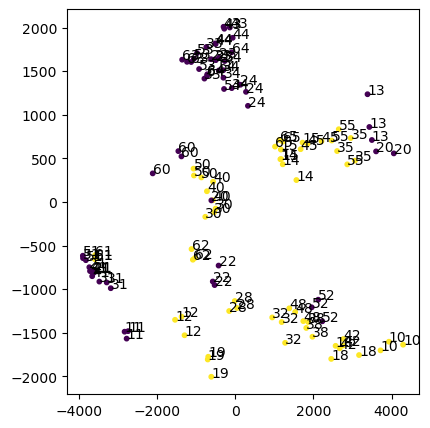

In [12]:
fig = plt.figure(figsize=(10, 5)) #Quality check if triplicates are close
ax = fig.add_subplot(121)
ax.scatter(finalDf2.iloc[:,0],finalDf2.iloc[:,1],c=finalDf2.iloc[:,2],s=10)
for i in range(120):
    ax.text(finalDf2.iloc[i,0],finalDf2.iloc[i,1],finalDf2.iloc[i,3],fontsize=10)
plt.show()

## Summing the triplicates together 

In [14]:
Df2=Df.drop('ECOLI',axis=1)
tripnames = []
for i in range(len(metadata2)):
    files = metadata2.iloc[i]
    
    files_a = files.iloc[1].strip() + ".fcs"
    files_b = files.iloc[2].strip() + ".fcs"
    files_c = files.iloc[3].strip() + ".fcs"
    
    
    trip1 = Df.loc[[files_a]]
    trip2 = Df.loc[[files_b]]
    trip3 = Df.loc[[files_c]]
    
    trip = pd.concat([trip1, trip2, trip3], axis=0)
    
    trip_sum = trip.iloc[:, :-1].sum(axis=0)
    trip_sum_df = pd.DataFrame(data=trip_sum).transpose()
    trip_sum_df["y/n"] = trip["y/n"].iloc[0]
    tripnames.extend([files_a, files_b, files_c])
    
    if i == 0:
        final_trip_sum_df = trip_sum_df
    else:
        final_trip_sum_df = pd.concat([final_trip_sum_df, trip_sum_df], axis=0
                                     )

trip_sum_df = final_trip_sum_df
trip_sum_df = trip_sum_df.drop('ECOLI',axis=1)


In [15]:
trip_sum_df.reset_index(drop=True, inplace=True)
trip_sum_df.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,y/n
0,0.0,0.0,0.0,0.0,0.0,0.0,91.0,72.0,0.0,0.0,...,0.0,80.0,22.0,18.0,8.0,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,9.0,11.0,0.0,0.0,...,0.0,49.0,28.0,9.0,6.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,48.0,36.0,0.0,0.0,...,0.0,48.0,25.0,21.0,8.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,22.0,17.0,0.0,0.0,...,0.0,45.0,16.0,16.0,14.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,15.0,11.0,0.0,0.0,...,0.0,39.0,15.0,12.0,5.0,0.0,0.0,0.0,0.0,2


In [16]:
trip_sum_df['y/n'].value_counts()

y/n
2    20
1    20
Name: count, dtype: int64

## Visualization of summed up triplicates (PCA)

In [18]:
principalComponents = pca.fit_transform(trip_sum_df.iloc[:,0:-1])
PCA_df=pd.DataFrame(principalComponents)
PCA_df.shape

(40, 2)

In [19]:
finalDf = pd.concat([PCA_df, trip_sum_df.iloc[:,-1]], axis = 1)
finalDf.head()

,0,1,y/n
0,8220.440169,-5164.298254,2
1,-90.047941,-3598.202874,2
2,5690.347067,-4337.256336,2
3,4686.278927,-3822.464686,2
4,-1966.246762,-5592.191296,2


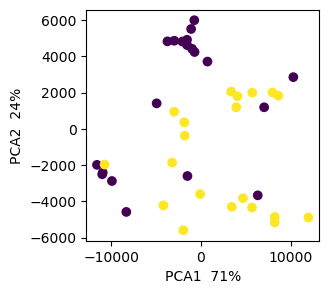

In [20]:
kvalitet=100*pca.explained_variance_ratio_
kvalitet_PCA1 = str(int(kvalitet[0]))
kvalitet_PCA2 = str(int(kvalitet[1]))


ax = plt.subplots(figsize=(3, 3))
plt.xlabel("PCA1"+"  "+kvalitet_PCA1+ "%")
plt.ylabel("PCA2"+"  "+kvalitet_PCA2+ "%")
plt.scatter(finalDf.iloc[:,0],finalDf.iloc[:,1],c=finalDf['y/n'])
plt.show()


## Normalizing features, remove feature magnitude (PCA visualization)

In [22]:
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(trip_sum_df.iloc[:,0:-1])
df_norm_indata=pd.DataFrame(data=x) 
trip_sum_df_norm = pd.concat([df_norm_indata, trip_sum_df.iloc[:,-1]], axis = 1)
trip_sum_df_norm.head(5)

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,y/n
0,0.0,0.0,0.0,0.0,0.0,0.0,4.418253,3.444908,0.0,0.0,...,0.0,3.009504,1.270618,0.376501,1.267113,-0.160128,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,-0.673760,-0.514383,0.0,0.0,...,0.0,0.734025,2.229576,-0.844582,0.568016,-0.160128,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,1.748051,1.108277,0.0,0.0,...,0.0,0.660623,1.750097,0.783528,1.267113,-0.160128,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.133510,-0.124945,0.0,0.0,...,0.0,0.440415,0.311661,0.105149,3.364403,-0.160128,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,-0.301174,-0.514383,0.0,0.0,...,0.0,0.000000,0.151835,-0.437555,0.218468,-0.160128,0.0,0.0,0.0,2


In [23]:
principalComponents = pca.fit_transform(trip_sum_df_norm.iloc[:,0:-1])
PCA_df=pd.DataFrame(principalComponents)
finalDf_norm = pd.concat([PCA_df, trip_sum_df_norm.iloc[:,-1]], axis = 1)
finalDf_norm.head()

,0,1,y/n
0,15.906877,-4.268631,2
1,2.130553,-0.384462,2
2,6.159876,-1.224000,2
3,3.498109,-0.718849,2
4,-0.691807,-2.527568,2


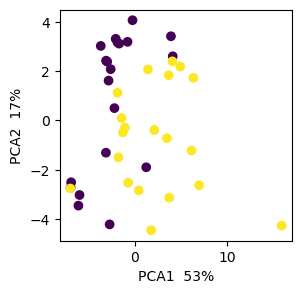

In [24]:
kvalitet=100*pca.explained_variance_ratio_
kvalitet_PCA1 = str(int(kvalitet[0]))
kvalitet_PCA2 = str(int(kvalitet[1]))
ax = plt.subplots(figsize=(3, 3))
plt.scatter(finalDf_norm.iloc[:,0],finalDf_norm.iloc[:,1],c=finalDf_norm['y/n'])
plt.xlabel("PCA1"+"  "+kvalitet_PCA1+ "%")
plt.ylabel("PCA2"+"  "+kvalitet_PCA2+ "%")
plt.show()

## TCC normalized and then feature normalized (PCA visualization)

In [26]:
trip_sum_df_features=trip_sum_df.drop('y/n',axis=1)
trip_sum_df_TCCnorm_features=trip_sum_df_features.div(trip_sum_df_features.sum(axis=1),axis=0)
trip_sum_df_TCCnorm = pd.concat([trip_sum_df_TCCnorm_features, trip_sum_df[['y/n']]], axis = 1)

In [27]:
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(trip_sum_df_TCCnorm.iloc[:,0:-1])
df_norm_indata=pd.DataFrame(data=x) 
trip_sum_df_TCCnorm_norm = pd.concat([df_norm_indata, trip_sum_df_TCCnorm.iloc[:,-1]], axis = 1)
trip_sum_df_TCCnorm_norm.head(5)

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,y/n
0,0.0,0.0,0.0,0.0,0.0,0.0,2.833289,1.875127,0.0,0.0,...,0.0,1.163728,-0.006700,-0.572793,0.317639,-0.160128,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,-0.785464,-0.491003,0.0,0.0,...,0.0,1.108746,2.387589,-0.924847,0.687278,-0.160128,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,1.259886,0.623685,0.0,0.0,...,0.0,-0.251398,0.826447,0.165607,0.673180,-0.160128,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,-0.133142,-0.311365,0.0,0.0,...,0.0,-0.240515,-0.151522,-0.309075,2.509349,-0.160128,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,-0.159186,-0.377641,0.0,0.0,...,0.0,0.667431,0.588096,-0.144544,0.592375,-0.160128,0.0,0.0,0.0,2


In [28]:
principalComponents = pca.fit_transform(trip_sum_df_TCCnorm_norm.iloc[:,0:-1])
PCA_df=pd.DataFrame(principalComponents)
finalDf_norm = pd.concat([PCA_df, trip_sum_df_TCCnorm_norm.iloc[:,-1]], axis = 1)
finalDf_norm.head(5)

,0,1,y/n
0,-9.552074,5.490497,2
1,-2.683442,6.654867,2
2,-3.615718,2.995302,2
3,-2.031613,2.344676,2
4,-3.599875,1.324401,2


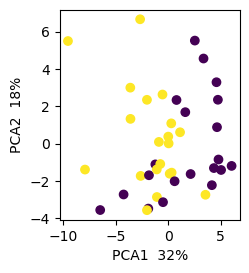

In [29]:
kvalitet=100*pca.explained_variance_ratio_
kvalitet_PCA1 = str(int(kvalitet[0]))
kvalitet_PCA2 = str(int(kvalitet[1]))

ax = plt.subplots(figsize=(3, 3))
plt.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.2)
plt.xlabel("PCA1"+"  "+kvalitet_PCA1+ "%")
plt.ylabel("PCA2"+"  "+kvalitet_PCA2+ "%")
plt.scatter(finalDf_norm.iloc[:,0],finalDf_norm.iloc[:,1],c=finalDf_norm['y/n'])
plt.show()

## Linear discriminant analysis to extract the Fisher discriminant ratio
LDA is used to extract a separation metric between the two classes in the three different PCA plots
The three PCA plots are based on three different datasets.
1) trip_sum_df
2) trip_sum_df_norm
3) trip_sum_df_TCCnorm_norm

Starting with trip_sum_df (Principal components with non-normalized TCC and features)

In [32]:
principalComponents = pca.fit_transform(trip_sum_df.iloc[:,0:-1])
PCA_df=pd.DataFrame(principalComponents)
finalDf = pd.concat([PCA_df, trip_sum_df.iloc[:,-1]], axis = 1)

dataset = finalDf

X = dataset.iloc[:, 0:2]
y = dataset.iloc[:, 2]

lda = LinearDiscriminantAnalysis(n_components=1)
trip_sum_df_lda =lda.fit_transform(X, y)

FDR = pd.DataFrame(trip_sum_df_lda, columns=['LDA'])
FDR['class']=y

LDA_1 = FDR[FDR['class'] == 1]
LDA_2 = FDR[FDR['class'] == 2]

mean_1 = LDA_1['LDA'].mean()
Sd_1 = LDA_1['LDA'].std()

mean_2 = LDA_2['LDA'].mean()
Sd_2 = LDA_2['LDA'].std()

FDR = ((mean_1-mean_2)**2)/Sd_1-Sd_2
FDR

1.2248061568637179

trip_sum_df_norm (Principal components with non-normalized TCC and feature normalization )

In [34]:
principalComponents = pca.fit_transform(trip_sum_df_norm.iloc[:,0:-1])
PCA_df=pd.DataFrame(principalComponents)
finalDf = pd.concat([PCA_df, trip_sum_df_norm.iloc[:,-1]], axis = 1)
dataset = finalDf

X = dataset.iloc[:, 0:2]
y = dataset.iloc[:, 2]

lda = LinearDiscriminantAnalysis(n_components=1)
trip_sum_df_norm_lda =lda.fit_transform(X, y)

FDR = pd.DataFrame(trip_sum_df_norm_lda, columns=['LDA'])
FDR['class']=y

LDA_1 = FDR[FDR['class'] == 1]
LDA_2 = FDR[FDR['class'] == 2]

mean_1 = LDA_1['LDA'].mean()
Sd_1 = LDA_1['LDA'].std()

mean_2 = LDA_2['LDA'].mean()
Sd_2 = LDA_2['LDA'].std()

FDR = ((mean_1-mean_2)**2)/Sd_1-Sd_2
FDR

2.010395195518951

In [35]:
principalComponents = pca.fit_transform(trip_sum_df_TCCnorm_norm.iloc[:,0:-1])
PCA_df=pd.DataFrame(principalComponents)
finalDf = pd.concat([PCA_df, trip_sum_df_TCCnorm_norm.iloc[:,-1]], axis = 1)
dataset = finalDf

X = dataset.iloc[:, 0:2]
y = dataset.iloc[:, 2]

lda = LinearDiscriminantAnalysis(n_components=1)
trip_sum_df_TCCnorm_norm_lda =lda.fit_transform(X, y)

FDR = pd.DataFrame(trip_sum_df_TCCnorm_norm_lda, columns=['LDA'])
FDR['class']=y

LDA_1 = FDR[FDR['class'] == 1]
LDA_2 = FDR[FDR['class'] == 2]

mean_1 = LDA_1['LDA'].mean()
Sd_1 = LDA_1['LDA'].std()

mean_2 = LDA_2['LDA'].mean()
Sd_2 = LDA_2['LDA'].std()

FDR = ((mean_1-mean_2)**2)/Sd_1-Sd_2
FDR

0.14274361154511084

## Machine learning analysis 

### Logistic regression

In [38]:
tabell=pd.DataFrame([[0,0,0,0]], columns=['Acc','Acc_1std','Sens','Sens_1std'])
tabell
accuracies=np.zeros(reruns)
sensitivities=np.zeros(reruns)
for j in range(reruns):
#for j in range(0):           
    X_train, X_test, y_train, y_test = train_test_split(trip_sum_df_norm.iloc[:,0:-1],trip_sum_df_norm[["y/n"]], test_size=0.2, random_state=None,stratify=trip_sum_df_norm[["y/n"]] )
    X_train_array=np.array(X_train)
    X_test_array=np.array(X_test)
    y_train_array=np.array(y_train['y/n'])
    y_test_array=np.array(y_test['y/n']) 
    
    log_reg = LogisticRegression(penalty=None)
    log_reg.fit(X_train_array,y_train_array)
    ypred_test_array=log_reg.predict(X_test_array)
    
    TP=(np.logical_and((ypred_test_array==2),(y_test_array==2))).sum()
    TN=(np.logical_and((ypred_test_array==1),(y_test_array==1))).sum()
    FP=(np.logical_and((ypred_test_array==2),(y_test_array==1))).sum()
    FN=(np.logical_and((ypred_test_array==1),(y_test_array==2))).sum()

    accuracy=(TP+TN)/(TP+TN+FP+FN)
    accuracies[j]=accuracy
    sensitivity=(TP)/(TP+FN)
    sensitivities[j]=sensitivity
    
tabell.iloc[0,0]=np.mean(accuracies)  
tabell.iloc[0,1]=np.std(accuracies)
tabell.iloc[0,2]=np.mean(sensitivities)  
tabell.iloc[0,3]=np.std(sensitivities)
tabell

C:\Users\IsabelErb\AppData\Local\Temp\ipykernel_42412\1241062789.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.727' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tabell.iloc[0,0]=np.mean(accuracies)
C:\Users\IsabelErb\AppData\Local\Temp\ipykernel_42412\1241062789.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.13796195127642985' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tabell.iloc[0,1]=np.std(accuracies)
C:\Users\IsabelErb\AppData\Local\Temp\ipykernel_42412\1241062789.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.726' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tabell.iloc[0,2]=np.me

,Acc,Acc_1std,Sens,Sens_1std
0,0.727,0.137962,0.726,0.21077


### Support Vector machines

In [40]:
from sklearn import svm

clf = svm.SVC(random_state=42)

tabell=pd.DataFrame([[0,0,0,0]], columns=['Acc','Acc_1std','Sens','Sens_1std'])
tabell
accuracies=np.zeros(reruns)
sensitivities=np.zeros(reruns)
for j in range(reruns):
#for j in range(0):           
    X_train, X_test, y_train, y_test = train_test_split(trip_sum_df_norm.iloc[:,0:-1],trip_sum_df_norm[["y/n"]],test_size=0.2, random_state=None,stratify=trip_sum_df_norm[["y/n"]] )
    X_train_array=np.array(X_train)
    X_test_array=np.array(X_test)
    y_train_array=np.array(y_train['y/n'])
    y_test_array=np.array(y_test['y/n'])    
    
    clf.fit(X_train_array,y_train_array)
    ypred_test_array=clf.predict(X_test_array)
    
    TP=(np.logical_and((ypred_test_array==2),(y_test_array==2))).sum()
    TN=(np.logical_and((ypred_test_array==1),(y_test_array==1))).sum()
    FP=(np.logical_and((ypred_test_array==2),(y_test_array==1))).sum()
    FN=(np.logical_and((ypred_test_array==1),(y_test_array==2))).sum()

    accuracy=(TP+TN)/(TP+TN+FP+FN)
    accuracies[j]=accuracy
    sensitivity=(TP)/(TP+FN)
    sensitivities[j]=sensitivity
    
tabell.iloc[0,0]=np.mean(accuracies)  
tabell.iloc[0,1]=np.std(accuracies)
tabell.iloc[0,2]=np.mean(sensitivities)  
tabell.iloc[0,3]=np.std(sensitivities)
tabell

C:\Users\IsabelErb\AppData\Local\Temp\ipykernel_42412\725042055.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.762' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tabell.iloc[0,0]=np.mean(accuracies)
C:\Users\IsabelErb\AppData\Local\Temp\ipykernel_42412\725042055.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.14376543395406283' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tabell.iloc[0,1]=np.std(accuracies)
C:\Users\IsabelErb\AppData\Local\Temp\ipykernel_42412\725042055.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7945' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tabell.iloc[0,2]=np.mean

,Acc,Acc_1std,Sens,Sens_1std
0,0.762,0.143765,0.7945,0.225044


### Random Forest

In [42]:
ran_for=RandomForestClassifier(n_estimators=100)
tabell=pd.DataFrame([[0,0,0,0]], columns=['Acc','Acc_1std','Sens','Sens_1std'])
tabell
accuracies=np.zeros(reruns)
sensitivities=np.zeros(reruns)
for j in range(reruns):
#for j in range(0):           
    X_train, X_test, y_train, y_test = train_test_split(trip_sum_df.iloc[:,0:-1],trip_sum_df[["y/n"]],test_size=0.2, random_state=None,stratify=trip_sum_df[["y/n"]] )
    X_train_array=np.array(X_train)
    X_test_array=np.array(X_test)
    y_train_array=np.array(y_train['y/n'])
    y_test_array=np.array(y_test['y/n'])    
    
    ran_for.fit(X_train_array,y_train_array)
    ypred_test_array=ran_for.predict(X_test_array)
    
    TP=(np.logical_and((ypred_test_array==2),(y_test_array==2))).sum()
    TN=(np.logical_and((ypred_test_array==1),(y_test_array==1))).sum()
    FP=(np.logical_and((ypred_test_array==2),(y_test_array==1))).sum()
    FN=(np.logical_and((ypred_test_array==1),(y_test_array==2))).sum()

    accuracy=(TP+TN)/(TP+TN+FP+FN)
    accuracies[j]=accuracy
    sensitivity=(TP)/(TP+FN)
    sensitivities[j]=sensitivity
    
tabell.iloc[0,0]=np.mean(accuracies)  
tabell.iloc[0,1]=np.std(accuracies)
tabell.iloc[0,2]=np.mean(sensitivities)  
tabell.iloc[0,3]=np.std(sensitivities)
tabell

C:\Users\IsabelErb\AppData\Local\Temp\ipykernel_42412\3321789165.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.80275' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tabell.iloc[0,0]=np.mean(accuracies)
C:\Users\IsabelErb\AppData\Local\Temp\ipykernel_42412\3321789165.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1348561733848325' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tabell.iloc[0,1]=np.std(accuracies)
C:\Users\IsabelErb\AppData\Local\Temp\ipykernel_42412\3321789165.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.831' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tabell.iloc[0,2]=np.m

,Acc,Acc_1std,Sens,Sens_1std
0,0.80275,0.134856,0.831,0.207217


## Random Forest: feature importance values

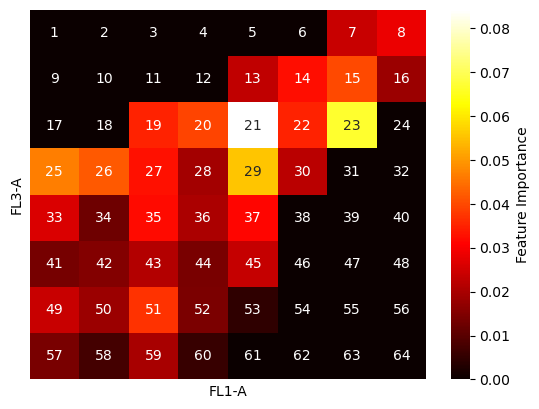

In [79]:
ran_for=RandomForestClassifier(n_estimators=500)
X_train_array=np.array(trip_sum_df.iloc[:,0:-1])
y_train_array=np.array(trip_sum_df["y/n"])
ran_for.fit(X_train_array,y_train_array)
ran_for.feature_importances_
feature_df=pd.DataFrame(ran_for.feature_importances_,index=Df.iloc[:,0:(pixels*pixels)].columns.values,columns=["kol1"], )

labels = np.arange(1, 65).reshape(8, 8)
string_labels = np.array(labels, dtype=str)

data = feature_df["kol1"].values.reshape((pixels, pixels))
sns.heatmap(data, annot=labels, cmap='hot', xticklabels=False, yticklabels=False, cbar_kws={'label': 'Feature Importance'})
plt.xlabel("FL1-A")
plt.ylabel("FL3-A")

plt.show()

### Random Forest two-threshold model, making use of the probability distribution

In [46]:
Thr_low=0.3
Thr_high=0.7
tabell=pd.DataFrame([[0,0,0,0,0,0]], columns=['Acc','Acc_1std','Sens','Sens_1std','IPF','IPF_1std'])

accuracies=np.zeros(reruns)
sensitivities=np.zeros(reruns)
IPFs=np.zeros(reruns)

for j in range(reruns):
#for j in range(0):        
    X_train, X_test, y_train, y_test = train_test_split(trip_sum_df_norm.iloc[:,0:-1],trip_sum_df_norm[["y/n"]],test_size=0.2, random_state=None,stratify=trip_sum_df[["y/n"]] )

    X_train_array=np.array(X_train)
    X_test_array=np.array(X_test)
    y_train_array=np.array(y_train['y/n'])
    y_test_array=np.array(y_test['y/n'])    
    
    ran_for.fit(X_train_array,y_train_array)
    ypred_test_array=ran_for.predict_proba(X_test_array)[:,1]
    
    TP=(np.logical_and((ypred_test_array>Thr_high),(y_test_array==2))).sum()
    TN=(np.logical_and((ypred_test_array<Thr_low),(y_test_array==1))).sum()
    FP=(np.logical_and((ypred_test_array>Thr_high),(y_test_array==1))).sum()
    FN=(np.logical_and((ypred_test_array<Thr_low),(y_test_array==2))).sum()

    accuracy=(TP+TN)/(TP+TN+FP+FN)
    accuracies[j]=accuracy
    #sensitivity=(TP)/(TP+FN)
    #sensitivities[j]=sensitivity
    IPFs[j]=(TP+TN+FP+FN)/len(ypred_test_array)
    
tabell.iloc[0,0]=np.mean(accuracies)  
tabell.iloc[0,1]=np.std(accuracies)
#tabell.iloc[0,2]=np.mean(sensitivities)  
#tabell.iloc[0,3]=np.std(sensitivities)
tabell.iloc[0,4]=np.mean(IPFs)  
tabell.iloc[0,5]=np.std(IPFs)

tabell

C:\Users\IsabelErb\AppData\Local\Temp\ipykernel_42412\2785142279.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8773619047619047' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tabell.iloc[0,0]=np.mean(accuracies)
C:\Users\IsabelErb\AppData\Local\Temp\ipykernel_42412\2785142279.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.14215563745687673' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tabell.iloc[0,1]=np.std(accuracies)
C:\Users\IsabelErb\AppData\Local\Temp\ipykernel_42412\2785142279.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6725' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tabell.i

,Acc,Acc_1std,Sens,Sens_1std,IPF,IPF_1std
0,0.877362,0.142156,0,0,0.6725,0.151017
